In [186]:
import pandas as pd
import numpy as np
import sqlite3

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import pickle

from sklearn.neural_network import MLPClassifier

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import seaborn as sns

## Get the musix match dataset and read it in

### 1. Read in the audio dataset

In [2]:
audio = pd.read_csv("./data/audio.csv")

In [13]:
db = sqlite3.connect("../mxm_dataset.db")
mxm = pd.read_sql("select * from lyrics", db)

### Merge with the audio data to get common tracks from both

In [14]:
lyrics = mxm.merge(audio[['track_id']], on='track_id')

In [15]:
mxm = None

In [16]:
lyrics.head()

,track_id,mxm_tid,word,count,is_test
0,TRAAAED128E0783FAB,2516445,i,28,0
1,TRAAAED128E0783FAB,2516445,the,15,0
2,TRAAAED128E0783FAB,2516445,you,2,0
3,TRAAAED128E0783FAB,2516445,to,12,0
4,TRAAAED128E0783FAB,2516445,and,22,0


In [17]:
lyrics.shape

(1502830, 5)

In [18]:
# save to csv file to do EDA
lyrics.to_csv("lyrics.csv")

### 3. Pivot the table to get a bag of words dataframe for each track and fill the missing values with 0

In [19]:
# lyrics = pd.read_csv("lyrics.csv")
lyrics = lyrics.pivot(index='track_id', columns='word', values='count')
lyrics = lyrics.fillna(0)

In [20]:
lyrics = lyrics.reset_index()

In [21]:
lyrics.head()

word,track_id,&,000,1,10,100,12,13,15,16,...,ça,è,é,él,était,être,ô,über,–,‘caus
0,TRAAAED128E0783FAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRAADFO128F92E1E91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TRAAENC128F1451DE9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TRAAFGQ128F427D884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRAAGOZ128F92EB3D4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
lyrics.shape

(17788, 5000)

### Merge again with audio to get the genre data

In [23]:
lyrics = lyrics.merge(audio[['track_id', 'Tag1']], on='track_id')

In [24]:
lyrics.head()

,track_id,&,000,1,10,100,12,13,15,16,...,è,é,él,était,être,ô,über,–,‘caus,Tag1
0,TRAAAED128E0783FAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jazz
1,TRAADFO128F92E1E91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Reggae
2,TRAAENC128F1451DE9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rock
3,TRAAFGQ128F427D884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rock
4,TRAAGOZ128F92EB3D4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pop


In [25]:
lyrics.Tag1.value_counts()

Rock          8762
Pop           1615
Metal         1393
Country       1125
Rap           1030
RnB            864
Electronic     667
Punk           504
Reggae         412
Folk           411
Jazz           356
Latin          299
Blues          263
World           60
New Age         27
Name: Tag1, dtype: int64

We see that "New Age" and "World" are not represented well in the above distribution and hence we drop these genres from classification.

In [26]:
lyrics = lyrics[lyrics.Tag1 != "New Age"]
lyrics = lyrics[lyrics.Tag1 != "World"]

In [27]:
lyrics = lyrics.reset_index()
lyrics.head()

,index,track_id,&,000,1,10,100,12,13,15,...,è,é,él,était,être,ô,über,–,‘caus,Tag1
0,0,TRAAAED128E0783FAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jazz
1,1,TRAADFO128F92E1E91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Reggae
2,2,TRAAENC128F1451DE9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rock
3,3,TRAAFGQ128F427D884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rock
4,4,TRAAGOZ128F92EB3D4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pop


## Read in the train and test files generated from the audio analysis of the data
(done separately)

In [28]:
X_train = pd.read_csv("./data/Processed/X_train.csv")
X_test = pd.read_csv("./data/Processed/X_test.csv")
y_train = pd.read_csv("./data/Processed/y_train.csv")
y_test = pd.read_csv("./data/Processed/y_test.csv")

### Subset out the data from the MusixMatch using the train and test set above

In [29]:
lyrics.head()

,index,track_id,&,000,1,10,100,12,13,15,...,è,é,él,était,être,ô,über,–,‘caus,Tag1
0,0,TRAAAED128E0783FAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jazz
1,1,TRAADFO128F92E1E91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Reggae
2,2,TRAAENC128F1451DE9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rock
3,3,TRAAFGQ128F427D884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rock
4,4,TRAAGOZ128F92EB3D4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pop


In [30]:
tfidf = TfidfTransformer()
tf_idf_matrix = tfidf.fit_transform(lyrics.iloc[:,2:5001])

In [31]:
tf_df = pd.DataFrame(tf_idf_matrix.toarray())
tf_df.columns = lyrics.columns[2:5001]

In [32]:
tf_df.head()

,&,000,1,10,100,12,13,15,16,2,...,ça,è,é,él,était,être,ô,über,–,‘caus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Add in the track_id and genre Tag from the lyrics dataframe

In [33]:
tf_df = pd.concat((tf_df, lyrics.iloc[:, [1,5001]]), axis=1)

In [34]:
tf_df.head()

,&,000,1,10,100,12,13,15,16,2,...,é,él,était,être,ô,über,–,‘caus,track_id,Tag1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TRAAAED128E0783FAB,Jazz
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TRAADFO128F92E1E91,Reggae
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TRAAENC128F1451DE9,Rock
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TRAAFGQ128F427D884,Rock
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TRAAGOZ128F92EB3D4,Pop


### Important for understanding the reason for keeping all words.

In [35]:
lyrics_train = lyrics[lyrics.track_id.isin(X_train.track_id)]
lyrics_test = lyrics[lyrics.track_id.isin(X_test.track_id)]

In [66]:
# tf_df[tf_df['était']!=0].head()
# tf_df.to_csv("tf_df.csv")

In [36]:
data_train = tf_df[tf_df.track_id.isin(X_train.track_id)]
data_test = tf_df[tf_df.track_id.isin(X_test.track_id)]

X_train = data_train.iloc[:, :4999]
y_train = data_train.iloc[:, 5000]
X_test = data_test.iloc[:, :4999]
y_test = data_test.iloc[:, 5000]

## Trying out RandomForestClassifier

In [25]:
rf = RandomForestClassifier()
params = {'n_estimators':[100, 500, 1000]}
gs = GridSearchCV(estimator=rf,scoring='accuracy',
                  param_grid=params,
                  n_jobs=1,
                  cv=3,
                  verbose=5)

gs.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=100 ................................................
[CV] ....... n_estimators=100, score=0.5515452289645838, total=  28.4s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.3s remaining:    0.0s


[CV] ....... n_estimators=100, score=0.5525186356449062, total=  27.5s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   57.8s remaining:    0.0s


[CV] ........ n_estimators=100, score=0.546112115732369, total=  27.8s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s


[CV] ....... n_estimators=500, score=0.5506429054816152, total= 2.4min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.9min remaining:    0.0s


[CV] ........ n_estimators=500, score=0.550259769595663, total= 2.3min
[CV] n_estimators=500 ................................................
[CV] ........ n_estimators=500, score=0.548372513562387, total= 2.1min
[CV] n_estimators=1000 ...............................................
[CV] ...... n_estimators=1000, score=0.5508684863523573, total= 4.7min
[CV] n_estimators=1000 ...............................................
[CV] ....... n_estimators=1000, score=0.550937429410436, total= 4.6min
[CV] n_estimators=1000 ...............................................
[CV] ...... n_estimators=1000, score=0.5474683544303798, total= 4.6min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 22.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [26]:
gs.best_score_

0.5500602228244504

In [27]:
pickle.dump(gs, open('random_forest_gs_actions.sav', 'wb'))

In [33]:
y_pred = gs.predict(X_test)

In [34]:
accuracy_score(y_test,y_pred)

0.5510527507357935

### Trying the multilayer perceptron

In [132]:
mlp = MLPClassifier(random_state = 9)
mlp.fit(X_train, y_train)

params = {'hidden_layer_sizes':[100, 150]}
gs_mlp = GridSearchCV(estimator=mlp,
                  scoring='accuracy',
                  param_grid=params,
                  n_jobs=1,
                  cv=3,
                  verbose=5)

gs_mlp.fit(X_train, y_train)

C:\Users\Saurav\Documents\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] hidden_layer_sizes=100 ..........................................


C:\Users\Saurav\Documents\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.8s remaining:    0.0s


[CV]  hidden_layer_sizes=100, score=0.44168734491315137, total=  42.8s
[CV] hidden_layer_sizes=100 ..........................................


C:\Users\Saurav\Documents\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV] . hidden_layer_sizes=100, score=0.4452224983058505, total=  47.6s
[CV] hidden_layer_sizes=100 ..........................................


C:\Users\Saurav\Documents\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s


[CV] . hidden_layer_sizes=100, score=0.4518535262206148, total=  48.6s
[CV] hidden_layer_sizes=150 ..........................................


C:\Users\Saurav\Documents\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.4min remaining:    0.0s


[CV] .. hidden_layer_sizes=150, score=0.449582675389127, total= 2.1min
[CV] hidden_layer_sizes=150 ..........................................


C:\Users\Saurav\Documents\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=150, score=0.45335441608312627, total= 2.1min
[CV] hidden_layer_sizes=150 ..........................................


C:\Users\Saurav\Documents\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.4min finished


[CV]  hidden_layer_sizes=150, score=0.44168173598553345, total= 2.0min


C:\Users\Saurav\Documents\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=9, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [133]:
y_pred_mlp = mlp.predict(X_test)

accuracy_score(y_test,y_pred_mlp)

0.452569617387367

In [48]:
pickle.dump(gs_mlp, open('mlp_gs_actions.sav', 'wb'))

### Filtering out some words from the 5000 word bag of words, like stopwords and numbers to see if it improves accuracy

In [46]:
columns = list(tf_df.columns)

In [48]:
words_wo_stopwords = []
for word in columns:
    if word not in set(STOPWORDS):
        words_wo_stopwords.append(word)

In [49]:
tf_df_wo_stop = tf_df[words_wo_stopwords]

In [54]:
tf_df_wo_stop.shape

(17701, 4888)

In [55]:
tf_df_wo_stop.columns

Index(['&', '000', '1', '10', '100', '12', '13', '15', '16', '2',
       ...
       'é', 'él', 'était', 'être', 'ô', 'über', '–', '‘caus', 'track_id',
       'Tag1'],
      dtype='object', length=4888)

We removed some 13 columns (words) from the dataframe. We also see some numbers in the bag of words chosen. Removing those might improve accuracy.

In [56]:
columns_only_string = []
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
for word in words_wo_stopwords:
    if not is_number(word):
        columns_only_string.append(word)

In [58]:
tf_df_wo_nums = tf_df_wo_stop[columns_only_string]

In [85]:
tf_df_wo_nums.shape

(17701, 4867)

A more simpler check might be to remove columns with more than 99% of the observations are 0's.

In [63]:
tf_df_wo_nums = tf_df_wo_nums.replace({'0':np.nan, 0:np.nan})

In [67]:
na_counts_per_col = (len(tf_df_wo_nums) - tf_df_wo_nums.count())*100/tf_df_wo_nums.shape[0]

In [73]:
use_cols = list(na_counts_per_col[na_counts_per_col <=99].index)

In [74]:
final_tf = tf_df_wo_nums[use_cols]

In [86]:
final_tf.shape

(17701, 1071)

In [81]:
final_tf = final_tf.fillna(0)

In [138]:
X_train = pd.read_csv("./data/Processed/X_train.csv")
X_test = pd.read_csv("./data/Processed/X_test.csv")
y_train = pd.read_csv("./data/Processed/y_train.csv")
y_test = pd.read_csv("./data/Processed/y_test.csv")

data_train = final_tf[final_tf.track_id.isin(X_train.track_id)]
data_test = final_tf[final_tf.track_id.isin(X_test.track_id)]

In [84]:
data_train.shape

(13284, 1071)

In [165]:
X_train = data_train.iloc[:, :1069]
y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :1069]
y_test = data_test.iloc[:, -1]

### Trying out RandomForestClassifier
On running grid search cross validation (not shown here), the best number of estimators came out to be 100. We will now vary the number of features, used for splitting since by default sklearn specifies sqrt(total features). Using all features for splitting might give better results.

In [126]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf= 20)
params = {'max_features':[1069]}
gs = GridSearchCV(estimator=rf,scoring='accuracy',
                  param_grid=params,
                  n_jobs=1,
                  cv=3,
                  verbose=5)

gs.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_features=1069 ...............................................
[CV] ...... max_features=1069, score=0.5425219941348973, total= 2.4min
[CV] max_features=1069 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[CV] ...... max_features=1069, score=0.5443867178676305, total= 2.3min
[CV] max_features=1069 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.7min remaining:    0.0s


[CV] ...... max_features=1069, score=0.5433996383363472, total= 2.4min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [1069]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=5)

In [128]:
gs.best_score_

0.5434357121348992

In [129]:
gs.best_params_

{'max_features': 1069}

In [98]:
y_pred_gs_1000 = gs.predict(X_test)

accuracy_score(y_test,y_pred_gs_1000)

0.5476567806203305

In [131]:
len(np.unique(y_pred_gs_1000))

12

We get comparable accuracy using smaller number of predictors.

### Using Gradient Boosting algorithm

After multiple runs, which are not shown here, we use learning rate of 0.05 and number of estimators as 500. We vary the max depth now, in our cross validation. 

With depth as 3 we saw a max accuracy score of 0.5538.

In [110]:
gb = GradientBoostingClassifier(max_features=100, n_estimators=500,  random_state = 0,learning_rate=0.05)
params = {'max_depth' : [3,5]}
gs = GridSearchCV(estimator=gb,scoring='accuracy',
                  param_grid=params,
                  n_jobs=1,
                  cv=3,
                  verbose=3)

gs.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] max_depth=3 .....................................................
[CV] ............ max_depth=3, score=0.5474847732912249, total= 1.6min
[CV] max_depth=3 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] ............ max_depth=3, score=0.5538739552744523, total= 1.9min
[CV] max_depth=3 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


[CV] ............ max_depth=3, score=0.5501808318264014, total= 1.5min
[CV] max_depth=5 .....................................................
[CV] ............ max_depth=5, score=0.5429731558763817, total= 2.8min
[CV] max_depth=5 .....................................................
[CV] ............ max_depth=5, score=0.5507115428055116, total= 2.9min
[CV] max_depth=5 .....................................................
[CV] ............ max_depth=5, score=0.5501808318264014, total= 2.9min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 14.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=100, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=3)

In [111]:
gs.best_score_

0.550511894007829

In [112]:
gs.best_params_

{'max_depth': 3}

In [114]:
pickle.dump(gs, open('gbm_gs_cv_actions.sav', 'wb'))

In [115]:
y_pred_gs_1000_2 = gs.predict(X_test)

accuracy_score(y_test,y_pred_gs_1000_2)

0.551279148743491

In [130]:
len(np.unique(y_pred_gs_1000_2))

13

In [127]:
predictions_gb = pd.Series(y_pred_gs_1000_2)
predictions_rf = pd.Series(y_pred_gs_1000)
val = pd.concat([predictions_gb, predictions_rf], axis=1)
val.to_csv('tree_text.csv', index = False)

In [137]:
final_tf.merge(audio, on="track_id", how='left').to_csv('merged.csv')

In [156]:
x_train = final_tf.merge(X_train, on='track_id')
x_test = final_tf.merge(X_test, on='track_id')

In [148]:
final_tf.head()

,&,abov,across,act,action,afraid,age,ago,ah,ahead,...,yeah,year,yes,yesterday,yet,yo,young,zu,track_id,Tag1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,TRAAAED128E0783FAB,Jazz
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009577,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,TRAADFO128F92E1E91,Reggae
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,TRAAENC128F1451DE9,Rock
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.042729,0.0,0.0,TRAAFGQ128F427D884,Rock
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022139,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,TRAAGOZ128F92EB3D4,Pop


## Ensemble Models

In [158]:
x_train.drop( ['Unnamed: 0', 'Unnamed: 0.1','track_id', 'Tag1'], inplace=True, axis=1)
x_test.drop( ['Unnamed: 0', 'Unnamed: 0.1','track_id', 'Tag1'], inplace=True, axis=1)

In [170]:
# list(x_train)[-80:]

In [167]:
rf = RandomForestClassifier(n_estimators=100)
params = {}
gs = GridSearchCV(estimator=rf,
                  scoring='accuracy',
                  param_grid=params,
                  n_jobs=1,
                  cv=3,
                  verbose=5)

gs.fit(x_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ....................... , score=0.5788405143243853, total=  11.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s


[CV] ........................ , score=0.574429636322566, total=  11.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.4s remaining:    0.0s


[CV] ........................ , score=0.583634719710669, total=  11.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [168]:
y_pred_ensemble = gs.predict(x_test)

In [169]:
accuracy_score(y_test, y_pred_ensemble)

0.5736925515055468

In [190]:
len(np.unique(y_pred_ensemble))

11

## Training on the whole dataset

In [191]:
rf = RandomForestClassifier(n_estimators=100)
gs_full = GridSearchCV(estimator=rf,
                  scoring='accuracy',
                  param_grid=params,
                  n_jobs=1,
                  cv=3,
                  verbose=5)

gs_full.fit(x_train, y_train)
gs_full.fit(pd.concat([x_train,x_test]), pd.concat([y_train,y_test]))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ....................... , score=0.5745544777802842, total=  10.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s


[CV] ....................... , score=0.5714931104585498, total=  10.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.6s remaining:    0.0s


[CV] ....................... , score=0.5795660036166366, total=  10.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ....................... , score=0.5762912785774768, total=  15.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.7s remaining:    0.0s


[CV] ....................... , score=0.5852542372881356, total=  15.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.2s remaining:    0.0s


[CV] ....................... , score=0.5793758480325645, total=  15.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   49.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   49.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [192]:
gs_full.best_score_

0.580306197389978

In [182]:
feature_list = list(x_train.columns)
importances = list(rf.feature_importances_)

#List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

#Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [184]:
len(feature_importances)

1109

## Confusion Matrices

### 1. For the Random Forest Model

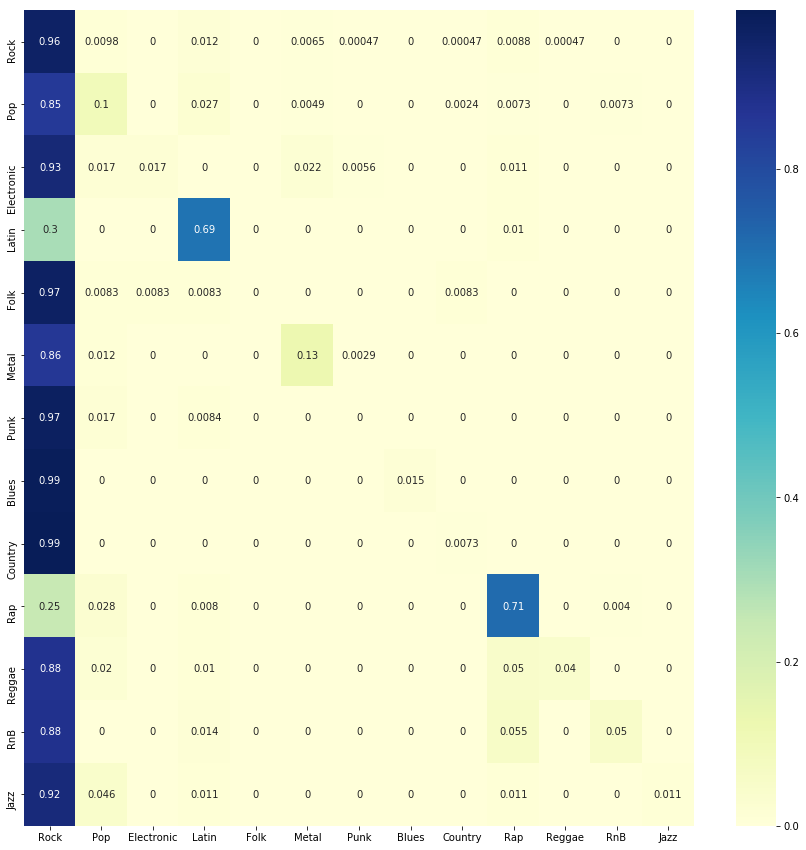

In [188]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
d = list(set(y_test.values))
conf = confusion_matrix(y_test, y_pred_gs_1000, labels = d)
normed_matrix = normalize(conf, axis=1, norm='l1')
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(normed_matrix, cmap="YlGnBu", ax = ax, xticklabels = d, yticklabels = d, annot = True)

### 2. For the random forest on the whole data

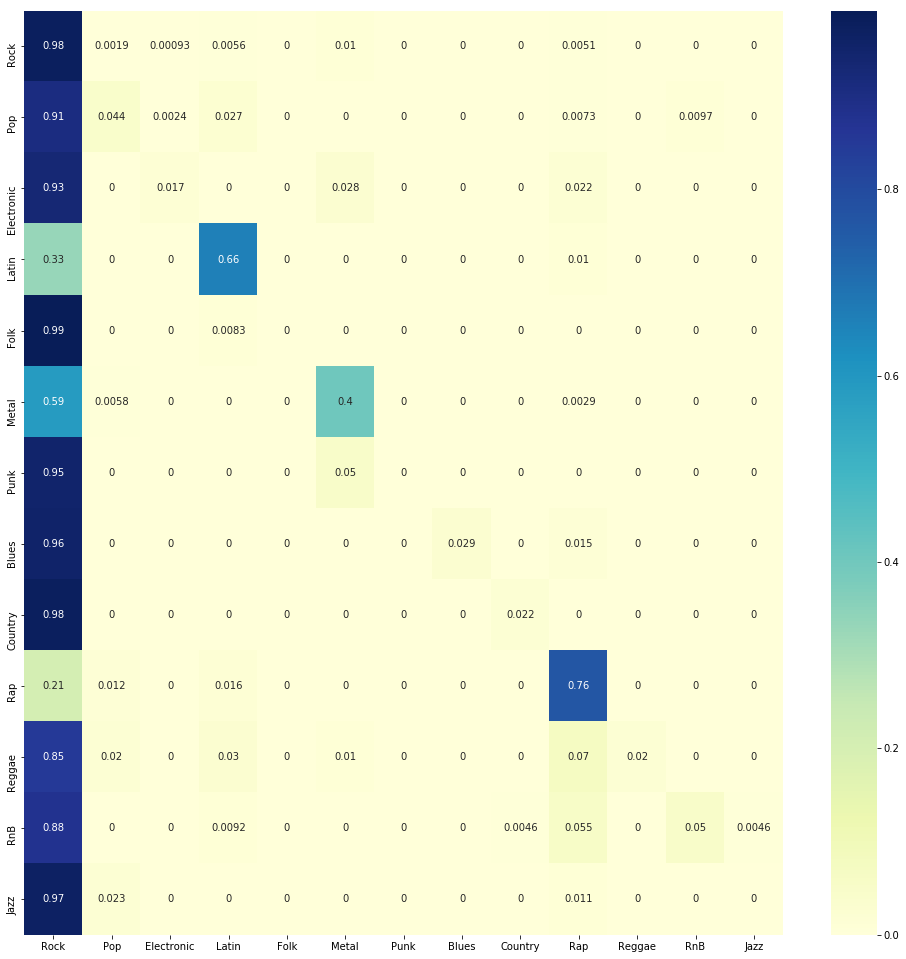

In [189]:
d = list(set(y_test.values))
conf = confusion_matrix(y_test, y_pred_ensemble, labels = d)
normed_matrix = normalize(conf, axis=1, norm='l1')
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(normed_matrix, cmap="YlGnBu", ax = ax, xticklabels = d, yticklabels = d, annot = True)